In [30]:
"""
Local Regression (LOESS) estimation routine.
"""
from functools import reduce
import numpy as np
import pandas as pd
import scipy
from scipy.spatial import distance
import statsmodels.api as sm
from scipy import linalg
from scipy import interpolate
from numpy.random import RandomState
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


np.set_printoptions(
    edgeitems=3, linewidth=200, suppress=True, nanstr='NaN',
    infstr='Inf', precision=5
    )

vdistance = np.vectorize(distance.euclidean)
prng = RandomState(516)





def bisquare_weight(arr):
    """
    Compute the bisquare weighted value of the array ``arr``.
    """
    return(np.power(1 - np.abs(np.power(arr, 2)), 2))

    

def tricube_weight(arr):
    """
    Compute the tricube weighted value of the array ``arr``.
    """
    return(np.power(1 - np.abs(np.power(arr, 3)), 3))


In [43]:
yarr

array([ 2.68584,  7.76526,  5.99367,  2.34942, 11.30883, 12.77624,  6.00059, 14.18739, 16.72226, 15.45805, 24.68882, 17.75659, 22.90757, 16.858  , 27.29387, 20.21337, 37.1513 , 32.40663])

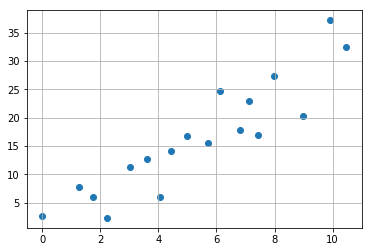

In [44]:
# xarr = np.asarray([0, 1.25, 1.75, 2.225, 3.01, 3.6, 4.07,  4.443, 4.967, 5.7, 6.12, 6.8, 7.11, 7.425, 7.991, 8.992, 9.898, 10.474])
# yarr = np.asarray([(3*i + prng.normal(0, scale=4.5))for i in xarr])

# xarr = np.array([0.   , 1.25 , 2.225, 3.6  , 4.443, 5.7  , 6.8  , 7.425, 8.992, 9.898])
# yarr = np.asarray([-0.73534,  7.13474,  9.18521,  9.89862, 11.27683, 13.3072 , 17.73304, 21.95513, 23.15692, 3.75])

xarr = np.asarray([ 0.   ,  1.25 ,  1.75 ,  2.225,  3.01 ,  3.6  ,  4.07 ,  4.443,  4.967,  5.7  ,  6.12 ,  6.8  ,  7.11 ,  7.425,  7.991,  8.992,  9.898, 10.474])
yarr = np.asarray([ 2.68584,  7.76526,  5.99367,  2.34942, 11.30883, 12.77624,  6.00059, 14.18739, 16.72226, 15.45805, 24.68882, 17.75659, 22.90757, 16.858  , 27.29387, 20.21337, 37.1513 , 32.40663])
plt.scatter(xarr, yarr)
plt.grid(True)
plt.show()


In [52]:
alpha = .80
degree = 1
max_cycles = 10
tolerance = .00001

xarr, yarr = xarr, yarr
arr = np.hstack([xarr.reshape(xarr.size, -1), yarr.reshape(yarr.size, -1)])
arr = arr[np.argsort(arr[:, 0])]
xvals, yvals = arr[:,0], arr[:,-1]
n = xvals.size
m = n + 1
q = int(np.ceil(n * alpha) if alpha <= 1.0 else n)
avg_interval = np.mean(xarr[1:] - xarr[:-1])
v_lb = np.min(xvals) - (.5 * avg_interval)
v_ub = np.max(xvals) + (.5 * avg_interval)

dfmodels = pd.DataFrame({
    "j":np.arange(1, m + 1, dtype=np.int),
    "v":np.linspace(start=v_lb, stop=v_ub, num=m, dtype=np.float),
    "g_0":np.NaN,
    "model0":None
    })

# Create design matrix based on degree.
X = np.hstack(
    [np.power(xvals, i).reshape(n, 1) for i in range(degree + 1)]
    )

for i in range(dfmodels.shape[0]):

    v_i = dfmodels.loc[i, "v"]
    
    # Compute distances to all points from val.
    distances_init = np.hstack(
        [xvals.reshape(n, -1), vdistance(v_i, xvals).reshape(n, -1)]
        )
    
    distances_init = distances_init[
        np.argsort(distances_init[:, 1])
        ]
    
    scale_factor = distances_init[
        q - 1, 1
        ]

    # distances_scaled[:,1] values <= 1 fall within current window.
    distances_scaled = distances_init / np.asarray([1., scale_factor])
    weights_init = np.where(
        distances_scaled[:,1]<=1, tricube_weight(distances_scaled[:,1]), 0
        )
    
    weights = np.hstack(
        [distances_scaled[:,[0]], weights_init.reshape(n, -1)]
        )
    
    weights = weights[
        np.argsort(weights[:,0])
        ]
    
    # Regress yvals on X using weights. 
    mdl = sm.WLS(yvals, X, weights=weights[:,1]).fit()
    
    mdl_eval = np.asarray([v_i**i for i in range(degree + 1)])
    
    g_i = mdl.get_prediction(mdl_eval).predicted_mean[0]
   
    dfmodels.loc[i, "g_0"] = g_i
    
    dfmodels.loc[i, "model0"] = mdl


dfmodels = dfmodels[["j", "v", "g_0", "model0"]]

dfmodels


,j,v,g_0,model0
0,1,-0.308059,1.196201,<statsmodels.regression.linear_model.Regressio...
1,2,0.308059,2.659627,<statsmodels.regression.linear_model.Regressio...
2,3,0.924176,4.157581,<statsmodels.regression.linear_model.Regressio...
3,4,1.540294,5.692745,<statsmodels.regression.linear_model.Regressio...
4,5,2.156412,7.257655,<statsmodels.regression.linear_model.Regressio...
5,6,2.772529,8.831761,<statsmodels.regression.linear_model.Regressio...
6,7,3.388647,10.411703,<statsmodels.regression.linear_model.Regressio...
7,8,4.004765,12.081539,<statsmodels.regression.linear_model.Regressio...
8,9,4.620882,13.874612,<statsmodels.regression.linear_model.Regressio...
9,10,5.237000,15.734768,<statsmodels.regression.linear_model.Regressio...


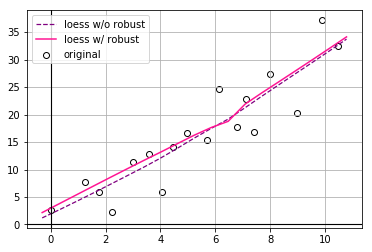

In [54]:
# Robustification step.
tolerance          = .00001
max_cycles         = 10

dfmodels["model1"] = None
dfmodels["g_1"]    = None



for j in range(dfmodels.shape[0]):
    
    mdl_old = dfmodels.loc[j, "model0"]
    
    b_old = mdl_old.params
    
    w_old = mdl_old.model.weights
    
    v_i = dfmodels.loc[j, "v"]
    
    cycle_nbr = 1

    while cycle_nbr<=max_cycles:

        e0_i = mdl_old.resid

        e1_i = (e0_i / (6 * np.median(np.abs(e0_i))))

        r_i = np.where(np.abs(e1_i) <= 1, bisquare_weight(e1_i), 0)

        w_new = w_old * r_i

        mdl_new = sm.WLS(yvals, X, weights=w_new).fit()

        b_new = mdl_new.params

        if np.all(np.abs(b_new - b_old)<tolerance):
            
            break

        w_old, b_old, mdl_old = w_new, b_new, mdl_new
        
        cycle_nbr+=1

      
    mdl_eval = np.asarray([v_i**i for i in range(degree + 1)])
    
    g_new = mdl_new.get_prediction(mdl_eval).predicted_mean[0]
    
    dfmodels.loc[j, "model1"] = mdl_new
    
    dfmodels.loc[j, "g_1"] = g_new
    
    

    
plt.scatter(xarr, yarr, color="white", edgecolor="black", label="original")
plt.plot(dfmodels.v, dfmodels.g_0, color="purple", linestyle="--", linewidth=1.25, label="loess w/o robust")
plt.plot(dfmodels.v, dfmodels.g_1, color="#ff1493", linestyle="-", linewidth=1.50, label="loess w/ robust")
plt.grid(True)
plt.axhline(0, color="#000000", linewidth=1.125)
plt.axvline(0, color="#000000", linewidth=1.125)
plt.legend(loc="upper left")
plt.show()


In [42]:
xarr

array([ 0.   ,  1.25 ,  1.75 ,  2.225,  3.01 ,  3.6  ,  4.07 ,  4.443,  4.967,  5.7  ,  6.12 ,  6.8  ,  7.11 ,  7.425,  7.991,  8.992,  9.898, 10.474])

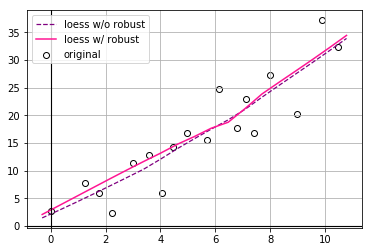

In [35]:
plt.scatter(xarr, yarr, color="white", edgecolor="black", label="original")
plt.plot(dfmodels.v, dfmodels.g_0, color="purple", linestyle="--", linewidth=1.25, label="loess w/o robust")
plt.plot(dfmodels.v, dfmodels.g_1, color="#ff1493", linestyle="-", linewidth=1.50, label="loess w/ robust")
plt.grid(True)
plt.axhline(0, color="#000000", linewidth=1.125)
plt.axvline(0, color="#000000", linewidth=1.125)
plt.legend(loc="upper left")
plt.show()



In [11]:
dfmodels

,j,v,g_0,model0,model1,g_1
0,1,-0.549889,-2.122668,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,-2.23758
1,2,0.549889,2.595686,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,2.56137
2,3,1.649667,6.832765,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,6.99314
3,4,2.749444,9.262665,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,9.26114
4,5,3.849222,10.571564,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,10.5691
5,6,4.949000,12.321271,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,12.2796
6,7,6.048778,15.502761,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,15.4542
7,8,7.148556,19.275407,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,19.3385
8,9,8.248333,18.795039,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,19.3131
9,10,9.348111,12.669621,<statsmodels.regression.linear_model.Regressio...,<statsmodels.regression.linear_model.Regressio...,12.5203


In [ ]:
    
#     print("weights_old: ", weights_old)
#     print("b_old      : ", b_old)
#     print("e0_i       : ", e0_i)
#     print("e1_i       : ", e1_i)
#     print("r_i        : ", r_i)
#     print("weights_new: ", weights_new)
#     print("b_new      : ", b_new)
#     print("b_diff     : ", b_new - b_old)
    
#     print("g_old      : ", g_old)
#     print("g_new      : ", g_new)

plt.scatter(xarr, yarr)
plt.plot(xarr, mdl_old.fittedvalues, color="grey")
# plt.plot(xarr, mdl_new.fittedvalues, color="red")
plt.plot(dfmodels.v, dfmodels.g_0, color="purple", linestyle=":")
plt.plot(dfmodels.v, dfmodels.g_1, color="purple", linestyle="--")
plt.grid(True)
plt.title("j={}".format(j))
plt.show()



In [ ]:
dfmodels

In [ ]:
xarr = np.asarray([0, 1.25, 2.225, 3.6, 4.443 ,5.7, 6.8, 7.425, 8.992, 9.898])
#yarr = np.asarray([(3*i + prng.normal(0, scale=3.5))for i in xarr])
yarr = np.asarray([-0.73534,  7.13474,  9.18521,  9.89862, 11.27683, 13.3072 , 17.73304, 21.95513, 23.15692, 3.75])
mm = sm.OLS(yarr, X).fit()
plt.scatter(xarr, yarr)
plt.plot(xarr, mdl_old.fittedvalues, color="red")
plt.plot(xarr, mm.fittedvalues, color="purple")
plt.grid(True)
plt.show()


In [ ]:
plt(mdl_old.fittedvalues

In [ ]:
e0_i

In [ ]:
local_est = mdl_old.get_prediction(x_i).predicted_mean[0]
e0_i = yvals[j] - local_est
e1_i = e0_i / (6 * np.median(np.abs(e0_i)))
# r_i = np.where(np.abs(e1_i) < 1, bisquare_weight(e1_i), 0)
r_i = np.where(np.abs(e1_i) < 1, .2654, 0)
weights_new = weights_old * r_i
mdl_new = sm.WLS(yvals, X, weights=weights_new).fit()
b_new, se_new = mdl_new.params, mdl_new.bse

print("weights_old: ", weights_old)
print("weights_new: ", weights_new)

print("b_old: ", b_old)
print("b_new: ", b_new)

In [ ]:
np.abs(e1_i)

In [ ]:
e0_i

In [ ]:
while cycle_nbr<=max_cycles:

    resid0 = mdl_old.resid
    resid1 = (resid0 / (6 * np.median(np.abs(resid0))))
    rr = np.where(np.abs(resid1) < 1, self.bisquare_weight(resid1), 0)
    weights_new = weights_old * rr
    mdl_new = sm.WLS(yvals, X, weights=weights_new).fit()
    b_new, se_new = mdl_new.params, mdl_new.bse

    if np.all(np.abs(b_new - b_old)<tolerance):
        break
    else:
        weights_old, b_old, mdl_old = weights_new, b_new, mdl_new
        cycle_nbr+=1

In [ ]:
j=0

fit_detail, weightslist = [], []
dfmodels["model1"] = None

val = dfmodels.loc[j, "v"]
mdl_old = dfmodels.loc[j, "model0"]
b_old = dfmodels.filter(regex="^b[0-9]{1,}_0", axis=1).loc[j,:].values
weights_old = dfweights_orig["weight_{}".format(j+1)].values
cycle_nbr = 0

while cycle_nbr<=max_cycles:

    resid0 = mdl_old.resid
    resid1 = (resid0 / (6 * np.median(np.abs(resid0))))
    rr = np.where(np.abs(resid1) < 1, self.bisquare_weight(resid1), 0)
    weights_new = weights_old * rr
    mdl_new = sm.WLS(yvals, X, weights=weights_new).fit()
    b_new, se_new = mdl_new.params, mdl_new.bse

    if np.all(np.abs(b_new - b_old)<tolerance):
        break
    else:
        weights_old, b_old, mdl_old = weights_new, b_new, mdl_new
        cycle_nbr+=1

# Save robustification details.
dfmodels.loc[j, "model1"] = mdl_new
local_input = np.asarray([val**k for k in range(degree + 1)])
local_est = mdl_new.get_prediction(local_input).predicted_mean[0]
fit_detail.append(np.hstack([val, b_new, se_new, local_est]))

weights_init = np.hstack(
    [xvals.reshape(n, -1), weights_new.reshape(n, -1)]
    )
weights = weights_init[
    np.argsort(weights_init[:,0])
    ]

dfweight = pd.DataFrame(weights).rename({0:"x", 1:"weight_{}".format(j+1)}, axis=1)
weightslist.append(dfweight)


In [ ]:
fit_detail, weightslist = [], []
dfmodels["model1"] = None

for j in range(dfmodels.shape[0]):

    val = dfmodels.loc[j, "v"]
    mdl_old = dfmodels.loc[j, "model0"]
    b_old = dfmodels.filter(regex="^b[0-9]{1,}_0", axis=1).loc[j,:].values
    weights_old = dfweights_orig["weight_{}".format(j+1)].values
    cycle_nbr = 0

    while cycle_nbr<=max_cycles:

        resid0 = mdl_old.resid
        resid1 = (resid0 / (6 * np.median(np.abs(resid0))))
        rr = np.where(np.abs(resid1) < 1, self.bisquare_weight(resid1), 0)
        weights_new = weights_old * rr
        mdl_new = sm.WLS(yvals, X, weights=weights_new).fit()
        b_new, se_new = mdl_new.params, mdl_new.bse

        if np.all(np.abs(b_new - b_old)<tolerance):
            break
        else:
            weights_old, b_old, mdl_old = weights_new, b_new, mdl_new
            cycle_nbr+=1

    # Save robustification details.
    dfmodels.loc[j, "model1"] = mdl_new
    local_input = np.asarray([val**k for k in range(degree + 1)])
    local_est = mdl_new.get_prediction(local_input).predicted_mean[0]
    fit_detail.append(np.hstack([val, b_new, se_new, local_est]))

    weights_init = np.hstack(
        [xvals.reshape(n, -1), weights_new.reshape(n, -1)]
        )
    weights = weights_init[
        np.argsort(weights_init[:,0])
        ]

    dfweight = pd.DataFrame(weights).rename({0:"x", 1:"weight_{}".format(j+1)}, axis=1)
    weightslist.append(dfweight)

    
  

In [ ]:
  
    
# Create dfloess.
dfloess = pd.DataFrame(
    np.vstack(fit_detail), columns=all_hdrs
    )

dfloess.columns = ["v"] + [i + "_1" for i in dfloess.columns if i!="v"]
dfmodels = dfmodels.merge(dfloess, how="inner", on="v")

# Create dfweights.
dfindex = weightslist[0].set_index("x").drop("weight_1", axis=1)
weightslist = [
    df.set_index("x") for df in weightslist
    ]
dfweights = reduce(
    lambda df1, df2: df1.join(df2), weightslist, dfindex
    )


# Create prediction DataFrame with Loess estimates from model0 and model1. 
dfpred = pd.DataFrame({
"x":xvals, "y":yvals, "loess0":np.NaN, "loess1":np.NaN
})

for ii in range(X.shape[0]):
x_i = X[ii, :]
mdl_indx = dfmodels[dfmodels.v<=x_i[1]].index.max()
mdl0 = dfmodels.loc[mdl_indx, "model0"]
mdl1 = dfmodels.loc[mdl_indx, "model1"]
dfpred.loc[ii, "loess0"] = mdl0.get_prediction(x_i).predicted_mean[0]
dfpred.loc[ii, "loess1"] = mdl1.get_prediction(x_i).predicted_mean[0]

In [ ]:
dfweights_orig

In [ ]:
dfweight

In [ ]:





# if robustify:

fit_detail, weightslist = [], []

dfmodels["model1"] = None




# for j in range(dfmodels.shape[0]):
    
j = 1
    
val = dfmodels.loc[j, "v"]

mdl_old = dfmodels.loc[j, "model0"]

b_old = dfmodels.filter(regex="^b[0-9]{1,}_0", axis=1).loc[j,:].values

weights_old = dfweights_orig["weight_{}".format(j+1)].values

cycle_nbr = 0

In [ ]:



class LoessRegressionEstimator:
    """
    Locally weighted regression estimator.
    """
    def __init__(self, x, y):
        
        self.x = np.asarray(x, dtype=np.float)
        self.y = np.asarray(y, dtype=np.float)
        
    
    @staticmethod
    def bisquare_weight(arr):
        """
        Compute the bisquare weighted value of the array ``arr``.
        """
        return(np.power(1 - np.abs(np.power(arr, 2)), 2))

    
    
    @staticmethod
    def tricube_weight(arr):
        """
        Compute the tricube weighted value of the array ``arr``.
        """
        return(np.power(1 - np.abs(np.power(arr, 3)), 3))

    
    
    def fit(self, alpha, degree=1, robustify=True, max_cycles=10, tolerance=.0001):
        """
        Perform locally-weighted regression (LOESS) on X & y.

        Parameters
        ----------
        alpha: float
            Specifies the number of observations to use for each local
            regression. ``alpha=.25`` indicates that 25% of the data will
            be used for each local estimate.

        degree: int
            The degree of the approximating polynomial used for each locally
            weighted regression estimate. Can be set to any positive integer,
            but the most commonly used values are 1 and 2. Setting ``poly_degree``
            greater than 2 tends to result in overfitting. Note that
            ``poly_degree=1`` corresponds to a 1st-degree polynomial approximation
            and ``poly_degree=2`` corresponds to 2nd-degree polynomial
            approximation.
            
        Returns
        -------
        """
        xarr, yarr = self.x, self.y
        arr = np.hstack([xarr.reshape(xarr.size, -1), yarr.reshape(yarr.size, -1)])
        arr = arr[np.argsort(arr[:, 0])]
        xvals, yvals = arr[:,0], arr[:,-1]
        n = xvals.size
        m = n + 1
        q = int(np.ceil(n * alpha) if alpha <= 1.0 else n)
        avg_interval = np.mean(xarr[1:] - xarr[:-1])
        v_lb = np.min(xvals) - (.5 * avg_interval)
        v_ub = np.max(xvals) + (.5 * avg_interval)

        # Create DataFrame containing Loess points of evaluation.
        dfmodels = pd.DataFrame({
            "j":np.arange(1, m + 1, dtype=np.int),
            "v":np.linspace(start=v_lb, stop=v_ub, num=m, dtype=np.float),
            "model0":None
            })

        # Create design matrix based on degree.
        X = np.hstack(
            [np.power(xvals, i).reshape(n, 1) for i in range(degree + 1)]
            )

        param_hdrs = ["b{}".format(i) for i in range(degree + 1)]
        stderr_hdrs = ["se_b{}".format(i) for i in range(degree + 1)]
        all_hdrs = ["v"] + param_hdrs + stderr_hdrs + ["g"]
        weightslist, fit_detail =  [], []


        for i in range(dfmodels.shape[0]):

            indx, val = dfmodels.loc[i, "j"], dfmodels.loc[i, "v"]

            # Compute distances to all points from val.
            distances_init = np.hstack(
                [xvals.reshape(n, -1), vdistance(val, xvals).reshape(n, -1)]
                )
            distances_init = distances_init[
                np.argsort(distances_init[:, 1])
                ]
            scale_factor = distances_init[
                q - 1, 1
                ]

            # distances_scaled[:,1] values <= 1 fall within current window.
            distances_scaled = distances_init / np.asarray([1., scale_factor])
            weights_init = np.where(
                distances_scaled[:,1]<=1, self.tricube_weight(distances_scaled[:,1]), 0
                )
            weights = np.hstack(
                [distances_scaled[:,[0]], weights_init.reshape(n, -1)]
                )
            weights = weights[
                np.argsort(weights[:,0])
                ]

            # Regress yvals on X using weights. 
            mdl = sm.WLS(yvals, X, weights=weights[:,1]).fit()
            b, se = mdl.params, mdl.bse
            local_input = np.asarray([val**i for i in range(degree + 1)])
            local_est = mdl.get_prediction(local_input).predicted_mean[0]
            fit_detail.append(np.hstack([val, b, se, local_est]))
            dfmodels.loc[i, "model0"] = mdl
            dfweight = pd.DataFrame(weights).rename({0:"x", 1:"weight_{}".format(indx)}, axis=1)
            weightslist.append(dfweight)

        dfloess_orig = pd.DataFrame(
            np.vstack(fit_detail), columns=all_hdrs
            )

        dfloess_orig.columns = ["v"] + [i + "_0" for i in dfloess_orig.columns if i!="v"]
        dfmodels = dfmodels.merge(dfloess_orig, how="inner", on="v")
        dfindex = weightslist[0].set_index("x").drop("weight_1", axis=1)
        weightslist = [
            df.set_index("x") for df in weightslist
            ]
        dfweights_orig = reduce(
            lambda df1, df2: df1.join(df2), weightslist, dfindex
            )
        
        
        if robustify:

            fit_detail, weightslist = [], []
            dfmodels["model1"] = None

            for j in range(dfmodels.shape[0]):

                val = dfmodels.loc[j, "v"]
                mdl_old = dfmodels.loc[j, "model0"]
                b_old = dfmodels.filter(regex="^b[0-9]{1,}_0", axis=1).loc[j,:].values
                weights_old = dfweights_orig["weight_{}".format(j+1)].values
                cycle_nbr = 0

                while cycle_nbr<=max_cycles:

                    resid0 = mdl_old.resid
                    resid1 = (resid0 / (6 * np.median(np.abs(resid0))))
                    rr = np.where(np.abs(resid1) < 1, self.bisquare_weight(resid1), 0)
                    weights_new = weights_old * rr
                    mdl_new = sm.WLS(yvals, X, weights=weights_new).fit()
                    b_new, se_new = mdl_new.params, mdl_new.bse

                    if np.all(np.abs(b_new - b_old)<tolerance):
                        break
                    else:
                        weights_old, b_old, mdl_old = weights_new, b_new, mdl_new
                        cycle_nbr+=1

                # Save robustification details.
                dfmodels.loc[j, "model1"] = mdl_new
                local_input = np.asarray([val**k for k in range(degree + 1)])
                local_est = mdl_new.get_prediction(local_input).predicted_mean[0]
                fit_detail.append(np.hstack([val, b_new, se_new, local_est]))

                weights_init = np.hstack(
                    [xvals.reshape(n, -1), weights_new.reshape(n, -1)]
                    )
                weights = weights_init[
                    np.argsort(weights_init[:,0])
                    ]

                dfweight = pd.DataFrame(weights).rename({0:"x", 1:"weight_{}".format(j+1)}, axis=1)
                weightslist.append(dfweight)

            # Create dfloess.
            dfloess = pd.DataFrame(
                np.vstack(fit_detail), columns=all_hdrs
                )
            
            dfloess.columns = ["v"] + [i + "_1" for i in dfloess.columns if i!="v"]
            dfmodels = dfmodels.merge(dfloess, how="inner", on="v")
            
            # Create dfweights.
            dfindex = weightslist[0].set_index("x").drop("weight_1", axis=1)
            weightslist = [
                df.set_index("x") for df in weightslist
                ]
            dfweights = reduce(
                lambda df1, df2: df1.join(df2), weightslist, dfindex
                )
        else:
            dfweights = dfweights_orig
            dfmodels["model1"] = dfmodels["model0"]
            dfmodels["g_1"] = dfmodels["g_0"]


        # Create prediction DataFrame with Loess estimates from model0 and model1. 
        dfpred = pd.DataFrame({
            "x":xvals, "y":yvals, "loess0":np.NaN, "loess1":np.NaN
            })
        
        for ii in range(X.shape[0]):
            x_i = X[ii, :]
            mdl_indx = dfmodels[dfmodels.v<=x_i[1]].index.max()
            mdl0 = dfmodels.loc[mdl_indx, "model0"]
            mdl1 = dfmodels.loc[mdl_indx, "model1"]
            dfpred.loc[ii, "loess0"] = mdl0.get_prediction(x_i).predicted_mean[0]
            dfpred.loc[ii, "loess1"] = mdl1.get_prediction(x_i).predicted_mean[0]

                 
        # Initialize and return LoessRegressionResult.
        loess_regression_result = LoessRegressionResult(
            xvals=self.x, yvals=self.y, alpha=alpha, degree=degree, robustify=robustify, 
            max_cycles=max_cycles, tolerance=tolerance, dfpred=dfpred, dfmodels=dfmodels, 
            dfweights=dfweights
            )
        
        return(loess_regression_result)
        



        
class LoessRegressionResult:
    """
    Loess regression results.
    """
    def __init__(self, xvals, yvals, alpha, degree, robustify, max_cycles, tolerance, 
                 dfpred, dfmodels, dfweights):
        
        self.xvals = xvals
        self.yvals = yvals
        self.alpha = alpha
        self.degree = degree
        self.robustify = robustify
        self.max_cycles = max_cycles
        self.tolerance = tolerance
        self.dfpred = dfpred
        self.dfmodels = dfmodels
        self.dfweights = dfweights
        
        # Properties.
        self._rsqrd = None
        
    
    
    def predict(v):
        """
        Return Loess estimate at point v. 
        """
        v_i = np.asarray([v**j for j in range(self.degree + 1)])
        mdl_indx = self.dfmodels[self.dfmodels.v>v].index.min()
        mdl = self.dfmodels.loc[mdl_indx, "model1"]
        return(mdl.get_prediction(v_i).predicted_mean[0])

    
    
    @property
    def _loess_r_sqrd():
        """
        Compute Loess R-squared.
        
        Parameters
        ----------
        actuals: np.ndarray
            Numpy array of actual observations.
        
        predictions: np.ndarray
            Numpy array of Loess regression estimates.
            
        Returns
        -------
        float
        """
        if self._rsqrd is None:
            actsarr = np.asarray(actuals)
            predsarr = np.asarray(predictions)
            preds_mean = predsarr.mean()
            acts_mean = actsarr.mean()
            self._rsqrd = ((predsarr - preds_mean)**2).sum() / ((actsarr - acts_mean)**2).sum()
        return(self._rsqrd)
    


In [ ]:
xarr = np.asarray([0, 1, 2, 3, 4 ,5, 6, 7, 8, 9])
yarr = np.asarray([-0.73534,  7.13474,  9.18521,  9.89862, 11.27683, 12.3072 , 18.73304, 22.95513, 23.15692, 7.75])

ALPHA      = .425
DEGREE     = 1
ROBUSTIFY  = True
MAX_CYCLES = 10
TOLERANCE  = .00001


mdl = LoessRegressionEstimator(x=xarr, y=yarr)

res = mdl.fit(
    alpha=ALPHA, degree=DEGREE, robustify=ROBUSTIFY, max_cycles=MAX_CYCLES, 
    tolerance=TOLERANCE
    )


Robustification output different than expected. 

In [ ]:
keepcols = ["v", "g_0", "g_1"]
dfout = res.dfmodels[keepcols]
dfout


In [ ]:
xvals = [.39,.75,1.1,1.45,1.95,2.46,3.07,3.44,4.57,5.05,5.68,
         6.01,6.63,7.11,7.62,8.01,8.54,9.08,9.48, 9.91]

yvals = [1.25*np.sqrt(i)+ prng.normal(0, .425) for i in xvals]

mdl0 = LoessRegressionEstimator(x=xvals, y=yvals).fit(alpha=.25, degree=1, robustify=False)
mdl1 = LoessRegressionEstimator(x=xvals, y=yvals).fit(alpha=.25, degree=1, robustify=True)

df0 = mdl0["dfdetail2"]
df1 = mdl1["dfdetail2"]

# summlist0 = mdl0["summary"]
# summlist1 = mdl1["summary"]
mdl0["rsqrd"]


In [ ]:
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6.5), dpi=100)

plt.scatter(
    xarr, yarr, color="grey", edgecolor="#000000",
    linewidth=.35, s=35, label="Original Observations"
    )
plt.plot(dfout.v.values, dfout.g_0.values, color="black", linewidth=1,
    label="w/o Robustify"
    )
plt.plot(dfout.v.values, dfout.g_1.values, color="red", linewidth=1.,
    label="w/ Robustify"
    )
plt.grid(True)
plt.show()

In [ ]:
xvals = [.39,.75,1.1,1.45,1.95,2.46,3.07,3.44,4.57,5.05,5.68,
         6.01,6.63,7.11,7.62,8.01,8.54,9.08,9.48, 9.91]

yvals = [1.25*np.sqrt(i) + prng.normal(0, .425) for i in xvals]

ALPHA  = .75
DEGREE = 1

mdl0 = LoessRegressionEstimator(x=xvals, y=yvals).fit(alpha=ALPHA, degree=DEGREE, robustify=False)
mdl1 = LoessRegressionEstimator(x=xvals, y=yvals).fit(alpha=ALPHA, degree=DEGREE, robustify=True)

summlist0 = mdl0["summary"]
summlist1 = mdl1["summary"]
dfloess1  = mdl0["dfdetail"]
dfloess2  = mdl1["dfdetail_orig"]

# Obtain reference to LOESS x & y values (v & g).
loessx1, loessy1 = dfloess1["v"].values, dfloess1["g"].values
loessx2, loessy2 = dfloess2["v"].values, dfloess2["g"].values

# Generate x-y scatterplot with loess estimate overlaid.
sns.set_style("darkgrid", {"axes.linewidth":.50, "axes.edgecolor":"#000000"})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), dpi=115)

sns.scatterplot(
    x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
    linewidth=.35, s=35, label="Original Observations", ax=ax[0]
    )
sns.lineplot(
    x=loessx1, y=loessy1, color="#9966cc", linewidth=1.25,
    label="Loess Estimate", ax=ax[0],
    )
ax[0].set_title(
    "Loess w/o Robustification",
    loc="left", color="red", fontsize=10,
    )
ax[0].legend(
    loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
    fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
    framealpha=.75,
    )
ax[0].tick_params(axis="x", which="major", labelsize=8)
ax[0].tick_params(axis="y", which="major", labelsize=8)

# Loess quadratic estimate.
sns.scatterplot(
    x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
    linewidth=.35, s=35, label="Original Observations", ax=ax[1]
    )
sns.lineplot(
    x=loessx2, y=loessy2, color="#9966cc", linewidth=1.25,
    label="Loess Estimate", ax=ax[1],
    )
ax[1].set_title(
    "LOESS w/ Robustification",
    loc="left", color="red", fontsize=10,
    )
ax[1].legend(
    loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
    fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
    framealpha=.75,
    )
ax[1].tick_params(axis="x", which="major", labelsize=8)
ax[1].tick_params(axis="y", which="major", labelsize=8)

plt.show()


In [ ]:

# Obtain reference to LOESS x & y values (v & g).
# loessx, loessy = dfdetail0["v"].values, dfdetail0["g"].values

# # Generate x-y scatterplot with loess estimate overlaid.
# sns.set_style("darkgrid", {"axes.linewidth":.50, "axes.edgecolor":"#000000"})
# fig, ax = plt.subplots(nrows=1, ncols=1, tight_layout=True)

# sns.scatterplot(
#     x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
#     linewidth=.35, s=35, label="Original observations",
#     )
# sns.lineplot(
#     x=loessx, y=loessy, color="#9966cc", linewidth=1.25,
#     label="LOESS 1st-degree polynomial estimate",
#     )
# ax.set_title(
#     "LOESS Estimate: 1st-degree Polynomial", loc="left", color="red",
#     fontsize=10
#     )
# ax.legend(
#     loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
#     fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
#     framealpha=.75,
#     )

# ax.tick_params(axis="x", which="major", labelsize=8)
# ax.tick_params(axis="y", which="major", labelsize=8)

# plt.show()

# # 1st - 2nd comparison =======================================================]
# import numpy as np
# import pandas as pd
# import scipy
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import seaborn as sns
# from numpy.random import RandomState
# mpl.rcParams["axes.linewidth"] = .5

# # prng = RandomState(516)

# # xvals = [.39,.75,1.1,1.45,1.95,2.46,3.07,3.44,4.57,5.05,5.68,
# #          6.01,6.63,7.11,7.62,8.01,8.54,9.08,9.48, 9.91]
# # yvals = [1.25*np.sqrt(i)+ prng.normal(0, .425) for i in xvals]


# result1 = loess(xvals, yvals, alpha=.55, poly_degree=1)
# dfloess1= result1["dfdetail"]

# result2 = loess(xvals, yvals, alpha=.55, poly_degree=2)
# dfloess2 = result2["dfdetail"]

# # Obtain reference to LOESS x & y values (v & g).
# loessx1, loessy1 = dfloess1["v"].values, dfloess1["g"].values
# loessx2, loessy2 = dfloess2["v"].values, dfloess2["g"].values


# # Generate x-y scatterplot with loess estimate overlaid.
# sns.set_style("darkgrid", {"axes.linewidth":.50, "axes.edgecolor":"#000000"})
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), tight_layout=True)

# sns.scatterplot(
#     x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
#     linewidth=.35, s=35, label="Original Observations", ax=ax[0]
#     )
# sns.lineplot(
#     x=loessx1, y=loessy1, color="#9966cc", linewidth=1.25,
#     label="Loess Estimate", ax=ax[0],
#     )
# ax[0].set_title(
#     "Loess Estimate: Linear Approximation", loc="left", color="red",
#     fontsize=10
#     )
# ax[0].legend(
#     loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
#     fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
#     framealpha=.75,
#     )
# ax[0].tick_params(axis="x", which="major", labelsize=8)
# ax[0].tick_params(axis="y", which="major", labelsize=8)

# # Loess quadratic estimate.
# sns.scatterplot(
#     x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
#     linewidth=.35, s=35, label="Original Observations", ax=ax[1]
#     )
# sns.lineplot(
#     x=loessx2, y=loessy2, color="#9966cc", linewidth=1.25,
#     label="Loess Estimate", ax=ax[1],
#     )
# ax[1].set_title(
#     "LOESS Estimate: Quadratic Approximation", loc="left", color="red",
#     fontsize=10
#     )
# ax[1].legend(
#     loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
#     fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
#     framealpha=.75,
#     )
# ax[1].tick_params(axis="x", which="major", labelsize=8)
# ax[1].tick_params(axis="y", which="major", labelsize=8)

# plt.show()



# Robustification ============================================================]
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import RandomState
mpl.rcParams["axes.linewidth"] = .5

prng = RandomState(15)

xvals = [.39,.75,1.1,1.45,1.95,2.46,3.07,3.44,4.57,5.05,5.68,
         6.01,6.63,7.11,7.62,8.01,8.54,9.08,9.48, 9.91]
yvals = [1.25*np.sqrt(i)+ prng.normal(0, .425) for i in xvals]

result1 = loess(xvals, yvals, alpha=.60, poly_degree=1, robustify=False)
dfloess1= result1["dfdetail"]

result2 = loess(xvals, yvals, alpha=.60, poly_degree=1, robustify=True)
dfloess2 = result2["dfdetail"]

# Obtain reference to LOESS x & y values (v & g).
loessx1, loessy1 = dfloess1["v"].values, dfloess1["g"].values
loessx2, loessy2 = dfloess2["v"].values, dfloess2["g"].values

# Generate x-y scatterplot with loess estimate overlaid.
sns.set_style("darkgrid", {"axes.linewidth":.50, "axes.edgecolor":"#000000"})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8), tight_layout=True)

sns.scatterplot(
    x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
    linewidth=.35, s=35, label="Original Observations", ax=ax[0]
    )
sns.lineplot(
    x=loessx1, y=loessy1, color="#9966cc", linewidth=1.25,
    label="Loess Estimate", ax=ax[0],
    )
ax[0].set_title(
    "Loess Linear Approximation Without Robustification",
    loc="left", color="red", fontsize=10,
    )
ax[0].legend(
    loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
    fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
    framealpha=.75,
    )
ax[0].tick_params(axis="x", which="major", labelsize=8)
ax[0].tick_params(axis="y", which="major", labelsize=8)

# Loess quadratic estimate.
sns.scatterplot(
    x=xvals, y=yvals, color="#FFFFFF", edgecolor="#000000",
    linewidth=.35, s=35, label="Original Observations", ax=ax[1]
    )
sns.lineplot(
    x=loessx2, y=loessy2, color="#9966cc", linewidth=1.25,
    label="Loess Estimate", ax=ax[1],
    )
ax[1].set_title(
    "LOESS Linear Approximation With Robustification",
    loc="left", color="red", fontsize=10,
    )
ax[1].legend(
    loc="upper left", scatterpoints=1, fontsize=9, frameon=True,
    fancybox=True, facecolor="#FFFFFF", edgecolor="#FFFFFF",
    framealpha=.75,
    )
ax[1].tick_params(axis="x", which="major", labelsize=8)
ax[1].tick_params(axis="y", which="major", labelsize=8)

plt.show()